In [59]:
# all internal libraries
import pathlib
import time
import datetime
import io
import urllib
import tempfile

# dependencies
import shapely.geometry
import networkx as nx
import simpy
import numpy as np
import pandas as pd

# our software
import opentnsim.core

%matplotlib inline

In [8]:
# link to the latets version of the network
url = 'https://zenodo.org/record/3981105/files/network_digital_twin_v0.1.yaml'


In [3]:
# Reading network (might take a few minutes on a slow connection)

# Create a temporary file
with tempfile.NamedTemporaryFile() as f:
    # download the network to the temporary file
    urllib.request.urlretrieve(url, f.name)
    G = nx.read_yaml(f.name)

# Making geometry really a geometry type
for n in G.nodes:
    G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])

PermissionError: [Errno 13] Permission denied: 'D:\\Users\\klef\\AppData\\Local\\Temp\\tmpwmnxycng'

In [5]:
# Reading network (might take a few minutes on a slow connection)

# Create a temporary file
f = tempfile.NamedTemporaryFile()
f.close()

urllib.request.urlretrieve(url, f.name)
G = nx.read_yaml(f.name)

# Making geometry really a geometry type
for n in G.nodes:
    G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])
    
del f

## Simple test

In [9]:
# get an edge from the network
edge = list(G.edges())[0]

In [10]:
# we're sailing from A to B
a = G.nodes[edge[0]]
b = G.nodes[edge[1]]

In [11]:
# Define the simulation environment
env = simpy.Environment()

In [12]:
# use an epoch based time
# See: https://en.wikipedia.org/wiki/Epoch_(computing)
simulation_start = datetime.datetime(2018, 7, 1)
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
# store the epoch so we can convert back
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = G

In [13]:
# Make a general vessel class out of mix-ins
TransportResource = type('TransportResource', 
                         (opentnsim.core.Identifiable, opentnsim.core.ContainerDependentMovable, 
                          opentnsim.core.HasResource, opentnsim.core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": a['geometry'],  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)


In [14]:
# Now define the sites (A and B)
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Log, opentnsim.core.Locatable, opentnsim.core.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(a['X'], a['Y'])}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(b['X'], b['Y'])}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)

nodes = [node_1, node_2]

In [15]:
# define the route along which we're going to sail
path = [edge]

In [16]:
# # Add environment and path to the vessel
vessel.env = env
vessel.route = path[0]
vessel.route

(8864523.0, 8864358.0)

In [17]:
# Now we can run a first simulation
def start(env, vessel):
    yield from vessel.move()
    vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
env.process(start(env, vessel))
env.run()


In [18]:
# The vessel should sail from A to B
# seems to be a double message on a move (fix in opentnsim)
vessel.log

{'Geometry': [<shapely.geometry.point.Point at 0x1fb57265cf8>,
 'Message': ['Sailing from node 8864523.0 to node 8864358.0 start',
  'Sailing from node 8864523.0 to node 8864358.0 stop',
  'Stop sailing'],
 'Timestamp': [datetime.datetime(2018, 7, 1, 0, 0),
  datetime.datetime(2018, 7, 1, 0, 3, 6, 965317),
  datetime.datetime(2018, 7, 1, 0, 3, 6, 965317)],
 'Value': [0, 0, '']}

## Repeat for real case

In [35]:
# Creating a library of some interesting locations

def find_closest_node(G, point):
    distance = np.full((len(G.nodes)), fill_value=np.nan)
    for ii, n in enumerate(G.nodes):
        distance[ii] = point.distance(G.nodes[n]['geometry'])
    name_node = list(G.nodes)[np.argmin(distance)]
    distance_node = np.min(distance)
    return name_node, distance_node

locations = {
    'Transferium Maasvlakte': shapely.geometry.Point(4.087406, 51.936737),
    'Neusse': shapely.geometry.Point(6.708892, 51.215737),
    'Basel': shapely.geometry.Point(7.640572, 47.555449)
}

locations_nodes = {n: find_closest_node(G, locations[n])[0] for n in locations}


In [36]:
# Find basic route
start_point = locations_nodes['Transferium Maasvlakte']
end_point = locations_nodes['Basel']
path = nx.dijkstra_path(G, start_point, end_point, weight='Length')

In [37]:
env = simpy.Environment()

In [38]:
simulation_start = datetime.datetime(2018, 7, 1)
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = G

In [39]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (opentnsim.core.Identifiable, opentnsim.core.ContainerDependentMovable, 
                          opentnsim.core.HasResource, opentnsim.core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": G.nodes[start_point]['geometry'],  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

In [45]:
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Log, opentnsim.core.Locatable, opentnsim.core.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": G.nodes[start_point]['geometry']}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": G.nodes[end_point]['geometry']}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)

nodes = [node_1, node_2]


In [46]:
# # Add environment and path to the vessel
vessel.env = env
vessel.route = path

In [47]:
def start(env, vessel):
    vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
    yield from vessel.move()
    vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
env.process(start(env, vessel))
env.run()


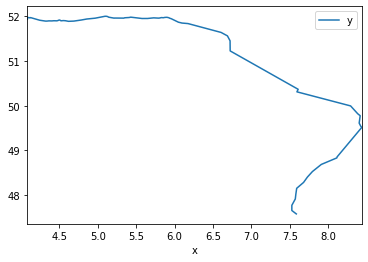

In [60]:
# get log and plot track
df = pd.DataFrame.from_dict(vessel.log)
df['x'] = df.Geometry.apply(lambda geom: geom.x)
df['y'] = df.Geometry.apply(lambda geom: geom.y)
df.plot('x', 'y')

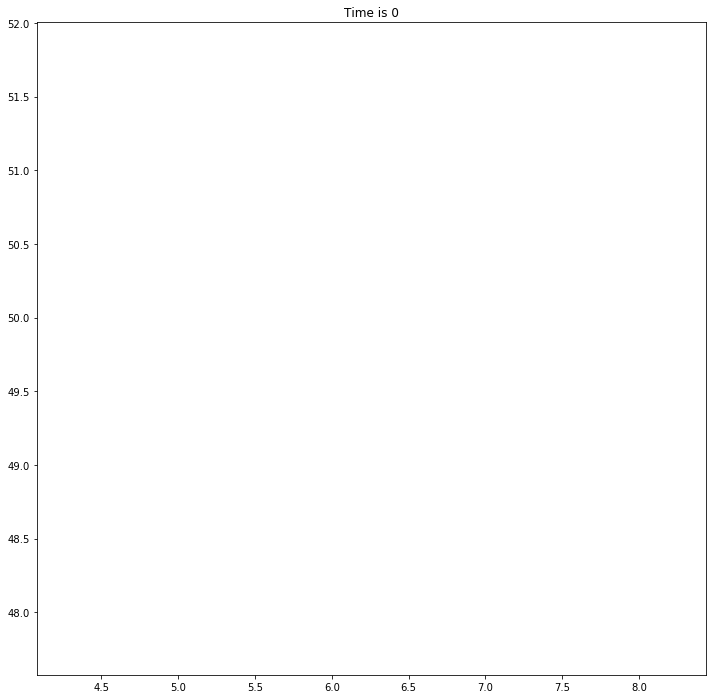

In [63]:
# Create plot of results

import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Get the coordinates of every step
coordinates = []
for i in vessel.log["Geometry"]:
    coordinates.append((i.x, i.y))
    
# Get the time of every step
timesteps = []
for i in vessel.log["Timestamp"]:
    timesteps.append(i.timestamp())

    
# coordinates = coordinates[:5]
# timesteps = timesteps[:5]
    
# Make the animation
fig, ax = plt.subplots(figsize = [12, 12])
ax.set_xlim(df['x'].min(), df['x'].max())
ax.set_ylim(df['y'].min(), df['y'].max())

spatial_pos = {
    k: (v['X'], v['Y']) 
    for k, v 
    in G.nodes.items()
}

#nx.draw(G, spatial_pos, 
#        with_labels = False, 
#        node_size = 0.5,
#        font_size = 2, 
#        width = 0.2, 
#        arrowsize = 3)

location, = plt.plot([], [], 'kx', markersize=15)
path, = plt.plot([], [], 'go', markersize=8)
time_text = plt.title("")

def init():
    location.set_data([], [])
    path.set_data([], [])
    time_text.set_text("Time is 0")

def animate(i):
    this_x = [coordinates[i][0]]
    this_y = [coordinates[i][1]]
    
    location.set_data(this_x, this_y)
    time_text.set_text("Time is {}".format(int(timesteps[i])))
    
    if 0 < i:
        past_x = [coordinate[0] for coordinate in coordinates[:i]]
        past_y = [coordinate[1] for coordinate in coordinates[:i]]
        
        path.set_data(past_x, past_y)
    
        return location, path, time_text
    
    else:
        return location, time_text
    
        
ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timesteps)), init_func=init)
ani.save('Route.mp4', fps=5)

In [62]:
!start explorer .